In [ ]:
from keras.callbacks import ModelCheckpoint
from keras import models
from keras.layers import Dense
import pandas as pd
import numpy as np



Using TensorFlow backend.


In [ ]:
def readData(path):
    data=pd.read_csv(path)
    return data
testingData=readData('/content/drive/My Drive/housingTest_Data.csv')
trainingData=readData('/content/drive/My Drive/housingTrain_Data.csv')

In [ ]:
def dropColumns(df):
    cols_to_drop=['Id','MiscFeature','PoolQC','Fence','FireplaceQu','Alley']
    df.drop(columns=cols_to_drop,inplace=True)
    return df

## Handling Missing Data
def handleMissingData(df):
    cols=df.columns
    for col in cols:
        if df[col].isnull().any():
            if df[col].dtype==np.dtype('object'):
                df[col]=df[col].fillna(df[col].mode().iloc[[0]][0])
            elif df[col].dtype==np.int64 or df[col].dtype==np.float64:
                df[col]=df[col].fillna(df[col].mean())
    return df

trainingData=dropColumns(trainingData)
trainingData=handleMissingData(trainingData)
testingData=dropColumns(testingData)
testingData=handleMissingData(testingData)



In [ ]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
trainingData=oneHotEncode(trainingData,trainingData.columns)
testingData=oneHotEncode(testingData,testingData.columns)

In [ ]:
target=trainingData['SalePrice']
def getCommonColumns(df1,df2):
    return list(set(df1.columns).intersection(set(df2.columns)))

common_columns=getCommonColumns(trainingData,testingData)
 
trainingData=trainingData[common_columns]
testingData=testingData[common_columns]
trainingData=pd.concat([trainingData,target],axis=1)



In [ ]:
XT=trainingData.values[:,:-1]
YT=trainingData.values[:,-1]

Xt=testingData.values

In [ ]:
model=models.Sequential()
model.add(Dense(100,kernel_initializer='normal',activation='relu',input_shape=(233,)))
model.add(Dense(50,kernel_initializer='normal',activation='relu'))
model.add(Dense(50,kernel_initializer='normal',activation='relu'))
model.add(Dense(50,kernel_initializer='normal',activation='relu'))
model.add(Dense(50,kernel_initializer='normal',activation='relu'))
model.add(Dense(1,activation='linear'))

model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['mean_absolute_error'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               23400     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 36,151
Trainable params: 36,151
Non-trainable params: 0
__________________________________________________

In [ ]:
checkpoint_name = 'weights.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:


hist=model.fit(XT,YT,epochs=1000,batch_size=32,validation_split=0.2,callbacks=callbacks_list)



Train on 880 samples, validate on 220 samples
Epoch 1/1000
880/880 [==============================] - 0s 260us/step - loss: 182275.5946 - mean_absolute_error: 182275.5781 - val_loss: 168606.9159 - val_mean_absolute_error: 168606.9062

Epoch 00001: val_loss improved from inf to 168606.91591, saving model to weights.hdf5
Epoch 2/1000
880/880 [==============================] - 0s 63us/step - loss: 124754.8685 - mean_absolute_error: 124754.8672 - val_loss: 60358.6933 - val_mean_absolute_error: 60358.6914

Epoch 00002: val_loss improved from 168606.91591 to 60358.69332, saving model to weights.hdf5
Epoch 3/1000
880/880 [==============================] - 0s 63us/step - loss: 54128.3625 - mean_absolute_error: 54128.3672 - val_loss: 41611.6381 - val_mean_absolute_error: 41611.6406

Epoch 00003: val_loss improved from 60358.69332 to 41611.63810, saving model to weights.hdf5
Epoch 4/1000
880/880 [==============================] - 0s 69us/step - loss: 49914.9531 - mean_absolute_error: 49914.9492 

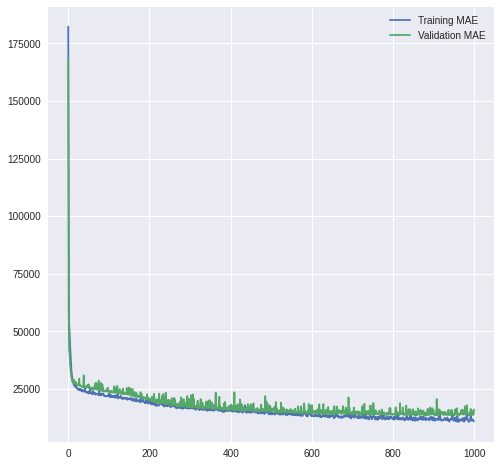

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
plt.style.use('seaborn')
    
def plotLosses(trainLoss,validationLoss):
    plt.plot(trainLoss,label='Training MAE')
    plt.plot(validationLoss,label='Validation MAE')
    plt.legend()
    plt.show()

plotLosses(hist.history['mean_absolute_error'],hist.history['val_mean_absolute_error'])

In [ ]:
model.load_weights('weights.hdf5')
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('weights.hdf5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

146820